# Measuring the Time Complexity of the Implementation

Since the algorithm iterates over the strings `2n` times, each substring `log(n)` times, and HashMap operations are assumed to be `O(1)`, we can classify its time complexity as **linear**. But it's always good to verify empirically, if possible. 

Slice the original string file into sub-files, increasing each by 5k lines

In [ ]:
%bash
for (( START=5000; START<=500000; START+=5000 )); do
    sed -n 1,"$START"p words.txt > files/words_$START.txt
done

Time the calculation using `Hyperfine`. There are 10 warm-up runs, followed by 20 measured runs.

In [ ]:
%bash
for (( START=5000; START<=500000; START+=5000 )); do
    hyperfine --warmup 10 --min-runs 20 -s basic 'target/release/patterns files/words_'"$START"'.txt' >> stats.txt
done

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import statsmodels
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import summary_table

import re

In [2]:
%matplotlib inline

Some plot customisation. You can skip this.

In [3]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Bitstream Vera Serif']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

In [4]:
# extract timings and noise
reg = re.compile(r"\S*:\s*(\d*\.\d*)\sms\s±\s*(\d*\.\d*)\sms")

In [5]:
fields = ['time', 'error']

with open("stats.txt", "r") as f:
    matches = (reg.findall(line) for line in f)
    cleaned = (m for m in matches if len(m))
    df = pd.DataFrame([dict(zip(fields, *entry)) for entry in cleaned])

In [6]:
# convert strings to float
df.time = pd.to_numeric(df.time)
df.error = pd.to_numeric(df.error)
# add number of entries
df['entries'] = np.array([e for e in xrange(5000, 505000, 5000)])

##  H$_0$: There is no linear relationship between number of strings and comparison time

In [7]:
fit = sm.ols(
    formula='time ~ entries',
    data=df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2860.
Date:                Fri, 23 Feb 2018   Prob (F-statistic):           2.53e-74
Time:                        11:19:15   Log-Likelihood:                -429.94
No. Observations:                 100   AIC:                             863.9
Df Residuals:                      98   BIC:                             869.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6205      3.628      3.479      0.001       5.421      19.820
entries        0.0007   1.25e-05     53.479      0.000       0.001       0.001
==============================================================================
Omnibus:                      150.851   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6839.132
Skew:                           5.450   Prob(JB):                         0.00
Kurtosis:                      42.020   Cond. No.                     5.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And plot the measurements and fitted line

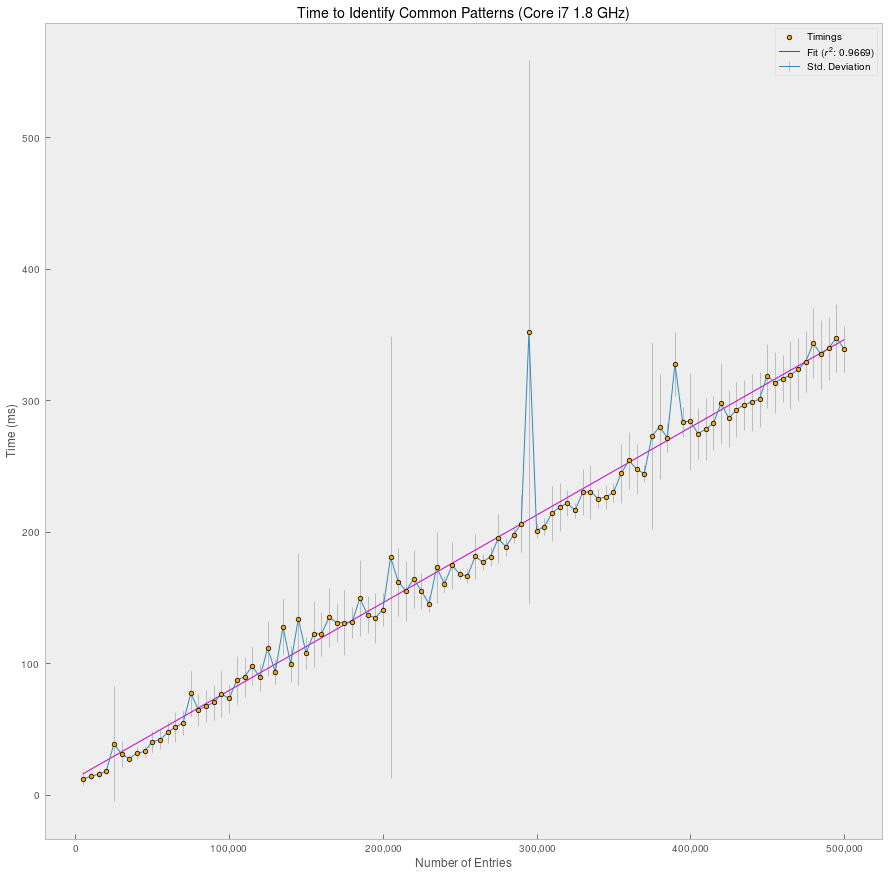

In [23]:
plt.clf()
fig = plt.figure(figsize=(15., 15.))
ax = fig.add_subplot(111)

measured = ax.scatter(
    df['entries'], df['time'],
    s=20., marker='o', color='#ffa500', edgecolor='#000000', lw=.75
)
err = plt.errorbar(
    df['entries'], df['time'], yerr=df['error'],
    ecolor='#bdbdbd', zorder=0
)
fitted, = plt.plot(
    df['entries'],
    fit.predict(),
    color='#CC00CC',
    zorder=0)

leg = plt.legend(
    (measured, fitted, err),
    ("Timings", "Fit ($r^2$: %0.4f)" % fit.rsquared, "Std. Deviation"))
ax.set_xlabel('Number of Entries')
ax.set_ylabel('Time (ms)')
ax.get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.title("Time to Identify Common Patterns (Core i7 1.8 GHz)")
plt.show()

###  H$_0$: rejected! There *is* a linear relationship. Thus: this implementation has O(n) time complexity